<a href="https://colab.research.google.com/github/pure-water/student_emotion/blob/main/ipynb/student_emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 This note book is based on FIR2003 dataset and a base model (Resnet and Mobilenet) for class student detection

In [ ]:
import sys
RUNTIME_IS_COLAB = 'google.colab' in sys.modules
print("Running in google Colab",RUNTIME_IS_COLAB)

Running in google Colab True


In [ ]:
! cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	:

In [ ]:
PROJECT_NAME = "student_emotion"
BATCH_SIZE = 64

In [ ]:

if (RUNTIME_IS_COLAB) :
  #Mount the Cloud Drive
  from google.colab import drive
  drive.mount('/content/gdrive')
  #Copy Over the Legacy File
  !ls /content/gdrive/MyDrive/$PROJECT_NAME/*
  !cp -r /content/gdrive/MyDrive/$PROJECT_NAME/*  .
  



Mounted at /content/gdrive
/content/gdrive/MyDrive/student_emotion/kaggle.json
/content/gdrive/MyDrive/student_emotion/model_resnet_FineTuned_ep100.h5
/content/gdrive/MyDrive/student_emotion/model_resnet_FineTuned_ep105.h5
/content/gdrive/MyDrive/student_emotion/model_resnet_FineTuned_ep90.h5
/content/gdrive/MyDrive/student_emotion/student_emotion.ipynb

/content/gdrive/MyDrive/student_emotion/training_work:
model_resnet_Finetuned-start-epoch65-0000.h5
model_resnet_Finetuned-start-epoch65-0005.h5


In [ ]:
if (RUNTIME_IS_COLAB):
  ! pip install kaggle
  ! mkdir -p ~/.kaggle
  ! cp /content/kaggle.json ~/.kaggle/
  ! chmod 600 ~/.kaggle/kaggle.json
  ! ls -la ~/.kaggle
  #! cat ~/.kaggle/kaggle.json
  #! cat /content/kaggle.json

total 16
drwxr-xr-x 2 root root 4096 Dec 18 07:43 .
drwx------ 1 root root 4096 Dec 18 07:43 ..
-rw------- 1 root root   63 Dec 18 07:43 kaggle.json


In [ ]:
from tensorflow import keras
#from keras.utils import np_utils
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input, UpSampling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from random import shuffle

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
print("tensorflow version", tf.version.VERSION)
! pip install kaggle
! mkdir -p ~/.kaggle
# Copy Twice, whatever 
if (RUNTIME_IS_COLAB) :
   ! cp kaggle.json ~/.kaggle/
else :
   !cp ~/Downloads/kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

!ls -ltr ~/.kaggle/

tensorflow version 2.7.0
total 4
-rw------- 1 root root 63 Dec 18 07:43 kaggle.json


Need to do something on this on local data set download

In [ ]:
!kaggle datasets download  msambare/fer2013

 94% 57.0M/60.3M [00:02<00:00, 16.3MB/s]
100% 60.3M/60.3M [00:02<00:00, 22.3MB/s]


In [ ]:
!unzip fer2013

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [ ]:

classes_num = 7
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

#YaoGang Colab Setup
#We need differenitate here with the local
if (RUNTIME_IS_COLAB) :
  HOME = "/content"
else:
  HOME =  "/home/nobond"
Train_DIR = HOME+"/train"
Test_DIR =  HOME+"/test"


#leagacy setup
##Train_DIR = "../input/fer2013/train"
##Test_DIR = "/content/test"

# one-hot:
def label_img(category):
    arr = np.zeros((classes_num,), dtype = int)
    arr[classes.index(category), ] = 1
    return arr

# Datasets:

img_size = 224
train = []
test = []
def create_train_set(img_size):
    for category in classes:
        imgs = 0
        category_path = os.path.join(Train_DIR, category)
        label = label_img(category)
        for img in os.listdir(category_path):
            imgs = imgs + 1
            if imgs == 4000:
                break
            img_array = cv2.resize(cv2.imread(os.path.join(category_path, img)), (img_size, img_size))
            train.append([np.array(img_array), np.array(label)])

create_train_set(img_size)
train = np.array(train)
test  = np.array(test)
shuffle(train)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
def plot_images(img_dir, top=10):
    all_img_dirs = os.listdir(img_dir)
    img_files = [os.path.join(img_dir, file) for file in all_img_dirs][:5]
  
    plt.figure(figsize=(10, 10))
  
    for idx, img_path in enumerate(img_files):
        plt.subplot(5, 5, idx+1)
        img = plt.imread(img_path)
        plt.tight_layout()         
        plt.imshow(img, cmap='gray') 

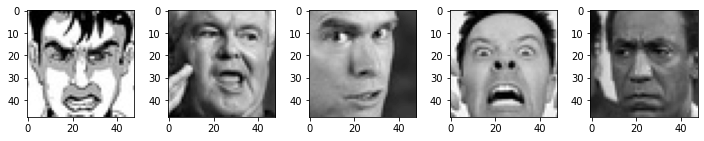

In [ ]:
plot_images('train'+'/angry')


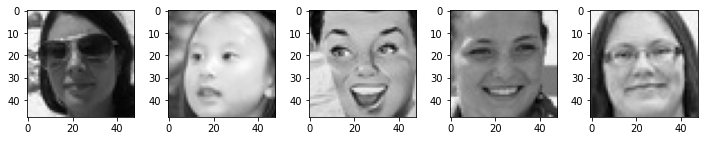

In [ ]:
plot_images('train'+'/happy')

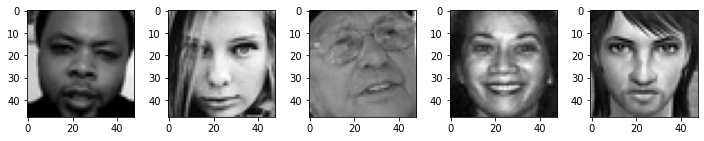

In [ ]:
plot_images('train'+'/neutral')

In [ ]:
# CREATING VALIDATION SET FROM A SUBSET OF TRAINING SET:

# valTOtrain_split_ratio = 0.2  # (val / total)
# num = int(((1 - valTOtrain_split_ratio)*train.shape[0]))
# train_set = train[:num]
# val_set = train[num:]

In [ ]:
import gc
split = int(train.shape[0]*0.8)
print("split threshold", split)
X_train = np.array([i[0] for i in train[:split]]).reshape(-1, img_size, img_size, 3)
y_train = np.array([i[1] for i in train[:split]])

print(X_train.shape)
print(y_train.shape)

X_val = np.array([i[0] for i in train[split:]]).reshape(-1, img_size, img_size, 3)
y_val = np.array([i[1] for i in train[split:]])

print(X_val.shape)
print(y_val.shape)

del train
gc.collect()

split threshold 18878
(18878, 224, 224, 3)
(18878, 7)
(4720, 224, 224, 3)
(4720, 7)


29985

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input, UpSampling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow import keras 


In [ ]:
# We shall not bmodel1.load_weights("/content/model_resnet_FineTuned_ep15+ep10.h5")uild a new model from scratch, rather we will use transfer learning:

img_size = 224
classes_num = 7
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow.keras.applications

resnet_model = ResNet50(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
mobilenet_model = tf.keras.applications.MobileNetV2(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
# Model1 using the resnet_model as the base model and fine tuning it

for layer in resnet_model.layers:
   layer.trainable = False
for layer in resnet_model.layers[-75:]:
   layer.trainable = True

# **IMPORTANT**
#let's visualize layer names and layer indices to see how many layers we should freeze:
for i, layer in enumerate(resnet_model.layers):
   print(i, layer.name)

model1 = Sequential()
model1.add(resnet_model)

model1.add(Flatten())
model1.add(BatchNormalization())

model1.add(Dense(classes_num, activation='softmax'))

model1.summary()

0 input_1
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

In [ ]:
#model1.load_weights("/content/model_resnet_FineTuned_25ep5.h5")
#model1.load_weights("/content/model_resnet_FineTuned_ep5+ep4+ep1.h5")
#model1.load_weights("/content/model_resnet_FineTuned_ep5+ep4+ep1+ep2.h5")
#model1.load_weights("/content/model_resnet_FineTuned_ep5+ep4+ep1+ep2+ep1.h5")

####The following is what we got on the training based on the above weight file
####Epoch 1/2
####295/295 [==============================] - 7394s 25s/step - loss: 0.5243 - accuracy: 0.9005 - val_loss: 8.2703 - val_accuracy: 0.6987
####Epoch 2/2
####295/295 [==============================] - 7688s 26s/step - loss: 0.1216 - accuracy: 0.9707 - val_loss: 8.9602 - val_accuracy: 0.7182
###model1.load_weights("/content/model_resnet_FineTuned_ep15+ep4.h5")
####Epoch 1/3
####295/295 [==============================] - 7138s 24s/step - loss: 0.2963 - accuracy: 0.9365 - val_loss: 10.2557 - val_accuracy: 0.7140
####Epoch 2/3
####295/295 [==============================] - 7145s 24s/step - loss: 0.1571 - accuracy: 0.9625 - val_loss: 11.4221 - val_accuracy: 0.7460
####Epoch 3/3
####295/295 [==============================] - 7199s 24s/step - loss: 0.0550 - accuracy: 0.9858 - val_loss: 11.2729 - val_accuracy: 0.7566
###model1.load_weights("/content/model_resnet_FineTuned_ep15+ep7.h5")
###Epoch 1/3
###295/295 [==============================] - 7360s 25s/step - loss: 0.2779 - accuracy: 0.9438 - val_loss: 11.4037 - val_accuracy: 0.7261
###Epoch 2/3
###295/295 [==============================] - 7410s 25s/step - loss: 0.0939 - accuracy: 0.9794 - val_loss: 13.2602 - val_accuracy: 0.7733
###Epoch 3/3
###295/295 [==============================] - 7376s 25s/step - loss: 0.0623 - accuracy: 0.9837 - val_loss: 12.0674 - val_accuracy: 0.7786
#model1.load_weights("/content/model_resnet_FineTuned_ep15+ep10.h5")
###Epoch 1/3
###295/295 [==============================] - 7294s 25s/step - loss: 0.2925 - accuracy: 0.9433 - val_loss: 12.1426 - val_accuracy: 0.7646
###Epoch 2/3
###295/295 [==============================] - 7232s 25s/step - loss: 0.0643 - accuracy: 0.9828 - val_loss: 11.9621 - val_accuracy: 0.7638
###Epoch 3/3
###295/295 [==============================] - 7231s 25s/step - loss: 0.0533 - accuracy: 0.9881 - val_loss: 16.5212 - val_accuracy: 0.735
#model1.load_weights("/content/model_resnet_FineTuned_ep15+ep15.h5")
#Epoch 1/3
#295/295 [==============================] - 296s 946ms/step - loss: 0.2837 - accuracy: 0.9527 - val_loss: 13.0006 - val_accuracy: 0.7756
#Epoch 2/3
#295/295 [==============================] - 272s 921ms/step - loss: 0.0909 - accuracy: 0.9817 - val_loss: 16.3783 - val_accuracy: 0.7716
#Epoch 3/3
#295/295 [==============================] - 272s 922ms/step - loss: 0.0579 - accuracy: 0.9881 - val_loss: 15.8719 - val_accuracy: 0.7782
#model1.load_weights("/content/model_resnet_FineTuned_ep15+ep18.h5")
#Epoch 1/2
#295/295 [==============================] - 250s 790ms/step - loss: 0.2488 - accuracy: 0.9578 - val_loss: 14.7065 - val_accuracy: 0.7818
#Epoch 2/2
#295/295 [==============================] - 227s 769ms/step - loss: 0.0791 - accuracy: 0.9821 - val_loss: 16.4920 - val_accuracy: 0.7309
#model1.load_weights("/content/model_resnet_FineTuned_ep15+ep20.h5")
#Epoch 1/2
#295/295 [==============================] - 250s 790ms/step - loss: 0.2488 - accuracy: 0.9578 - val_loss: 14.7065 - val_accuracy: 0.7818
#Epoch 2/2
#295/295 [==============================] - 227s 769ms/step - loss: 0.0791 - accuracy: 0.9821 - val_loss: 16.4920 - val_accuracy: 0.7800
#model1.load_weights("/content/model_resnet_FineTuned_ep38.h5")
#Epoch 1/2
#295/295 [==============================] - 7181s 24s/step - loss: 0.2693 - accuracy: 0.9539 - val_loss: 12.4818 - val_accuracy: 0.7841
#Epoch 2/2
#295/295 [==============================] - 7275s 25s/step - loss: 0.0599 - accuracy: 0.9861 - val_loss: 13.4413 - val_accuracy: 0.7761
#295/295 [==============================] - 294s 944ms/step - loss: 0.3079 - accuracy: 0.9600 - val_loss: 22.6596 - val_accuracy: 0.7807
#Epoch 2/10
#295/295 [==============================] - 272s 921ms/step - loss: 0.0563 - accuracy: 0.9869 - val_loss: 22.3197 - val_accuracy: 0.7875
#Epoch 3/10
#295/295 [==============================] - 272s 921ms/step - loss: 0.0230 - accuracy: 0.9944 - val_loss: 22.3572 - val_accuracy: 0.7833
#Epoch 4/10
#295/295 [==============================] - 272s 921ms/step - loss: 0.0170 - accuracy: 0.9959 - val_loss: 22.3768 - val_accuracy: 0.7828
#Epoch 5/10
#293/295 [============================>.] - ETA: 1s - loss: 0.0137 - accuracy: 0.9975
#Epoch 00005: saving model to /content/gdrive/MyDrive/student_emotion/training_work/model_resnet_Finetuned-start-epoch65-0005.h5
#295/295 [==============================] - 273s 925ms/step - loss: 0.0140 - accuracy: 0.9975 - val_loss: 22.8170 - val_accuracy: 0.7780
#Epoch 6/10
#295/295 [==============================] - 272s 921ms/step - loss: 0.0104 - accuracy: 0.9980 - val_loss: 22.2540 - val_accuracy: 0.7845
#Epoch 7/10
#295/295 [==============================] - 272s 921ms/step - loss: 0.0118 - accuracy: 0.9976 - val_loss: 22.6760 - val_accuracy: 0.7841
#Epoch 8/10
#295/295 [==============================] - 271s 920ms/step - loss: 0.0155 - accuracy: 0.9976 - val_loss: 22.7845 - val_accuracy: 0.7797

if (RUNTIME_IS_COLAB) :
    model1.load_weights("/content/model_resnet_FineTuned_ep105.h5")
else : 
    model1.load_weights("/home/nobond/Downloads/model_resnet_FineTuned_ep105.h5")
##################################################################

In [ ]:
# Include the epoch in the file name (uses `str.format`)

if (RUNTIME_IS_COLAB ) : 
    gdrive_path = "/content/gdrive/MyDrive/student_emotion/"
else : 
    gdrive_path = "/home/nobond/workspace/student_emotion/"

training_work_path = gdrive_path + "training_work/"

#training_work_path = "student_emotion_training_work"
os.makedirs(training_work_path,exist_ok=True)
checkpoint_path =training_work_path + 'model_resnet_Finetuned-start-epoch65-{epoch:04d}.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)
print(checkpoint_dir)

BATCH_SIZE = 64 
STEP_PER_EPOCH = y_train.shape[0]/BATCH_SIZE
SAVE_PEROID = 5 ## Whatever number you want to save

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=int(STEP_PER_EPOCH * SAVE_PEROID)) ## should just be one epoch rather than something else


# Save the weights using the `checkpoint_path` format
model1.save_weights(checkpoint_path.format(epoch=0))

/content/gdrive/MyDrive/student_emotion/training_work


In [ ]:
model1.compile(optimizer=Adam(learning_rate=0.00006),loss='categorical_crossentropy',metrics=['accuracy'])
history1 = model1.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs=15, callbacks=[cp_callback],validation_data=(X_val, y_val))

model_file = "model_resnet_FineTuned_ep120.h5"
model1.save_weights(model_file)

!cp $model_file /content/gdrive/MyDrive/student_emotion/.


from google.colab import files
files.download(model_file)

Epoch 1/15
295/295 [==============================] - 239s 754ms/step - loss: 0.1769 - accuracy: 0.9753 - val_loss: 20.2577 - val_accuracy: 0.8068
Epoch 2/15
295/295 [==============================] - 218s 739ms/step - loss: 0.0472 - accuracy: 0.9903 - val_loss: 20.3567 - val_accuracy: 0.8034
Epoch 3/15
295/295 [==============================] - 218s 739ms/step - loss: 0.0173 - accuracy: 0.9951 - val_loss: 20.3592 - val_accuracy: 0.8053
Epoch 4/15
295/295 [==============================] - 218s 739ms/step - loss: 0.0130 - accuracy: 0.9965 - val_loss: 20.6598 - val_accuracy: 0.8057
Epoch 5/15
293/295 [============================>.] - ETA: 1s - loss: 0.0107 - accuracy: 0.9975
Epoch 00005: saving model to /content/gdrive/MyDrive/student_emotion/training_work/model_resnet_Finetuned-start-epoch65-0005.h5
295/295 [==============================] - 218s 741ms/step - loss: 0.0106 - accuracy: 0.9976 - val_loss: 20.5910 - val_accuracy: 0.8044
Epoch 6/15
295/295 [==============================] 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!cp $model_file  /content/gdrive/MyDrive/student_emotion/.

In [ ]:
from google.colab import files
files.download(model_file)


In [ ]:
!ls -la

In [ ]:
！nvidia-smi

SyntaxError: ignored

In [ ]:
model2.save("model_mobilenet_input_224")